Wavenet 2016 from DeepMind

In [2]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

Vocab

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [43]:
block_size = 8

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [47]:
[x.item() for x in X_train[0]]

[0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> t
.......t ---> a
......ta ---> u
.....tau ---> r
....taur ---> e
...taure ---> n
..tauren ---> .
........ ---> s
.......s ---> u
......su ---> l
.....sul ---> e
....sule ---> m
...sulem ---> a
..sulema ---> n
.suleman ---> .
........ ---> z
.......z ---> e
......ze ---> r
.....zer ---> e
....zere ---> n


In [69]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):    
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum * self.running_var) + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]


class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape #4, 8, 10
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

    
#container to keep all layers in 
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [26]:
torch.manual_seed(42)

In [79]:
n_embed = 10 #dim of the char embeddings
n_hidden = 68 #num of neurons in the hidden layer of MLP

#hierarchical layers
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    #make last layer less confident
    model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


22397


In [77]:
#look at 4 examples
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  5,  3],
        [ 0,  0,  0,  0,  4,  1, 12, 12],
        [ 0,  0,  0,  1, 12,  9, 19, 19]])

In [78]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [56]:
#output of embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [57]:
#output of Flatten layer
model.layers[1].out.shape

torch.Size([4, 80])

In [58]:
#output of linear layer
model.layers[2].out.shape

torch.Size([4, 200])

- For wavenet we want to gradually squish the chars from 8 to 1, taking bigrams at a time
- These are hierarchical layers

In [ ]:
#(1,2), (3,4), (5,6), (7,8)
#(1,2), (3,4)
#(1,2)

In [60]:
#right now we are doing in first layer:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [62]:
#what we want to do:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

- So we need to change the Flatten layer to create 4,4,20

In [66]:
e = torch.randn(4, 8, 10)
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

torch.Size([4, 4, 20])

In [68]:
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

In [80]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    

      0/ 200000: 3.3122
  10000/ 200000: 1.8064
  20000/ 200000: 1.6946
  30000/ 200000: 1.4322
  40000/ 200000: 2.0991
  50000/ 200000: 2.1171
  60000/ 200000: 2.1023
  70000/ 200000: 1.9116
  80000/ 200000: 1.8841
  90000/ 200000: 2.3658
 100000/ 200000: 1.7228
 110000/ 200000: 1.7266
 120000/ 200000: 2.1166
 130000/ 200000: 1.8355
 140000/ 200000: 1.5797
 150000/ 200000: 1.8766
 160000/ 200000: 1.9425
 170000/ 200000: 2.0603
 180000/ 200000: 1.5164
 190000/ 200000: 2.2172


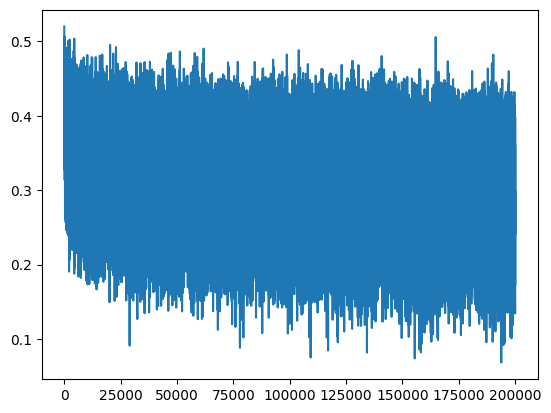

In [81]:
plt.plot(lossi)

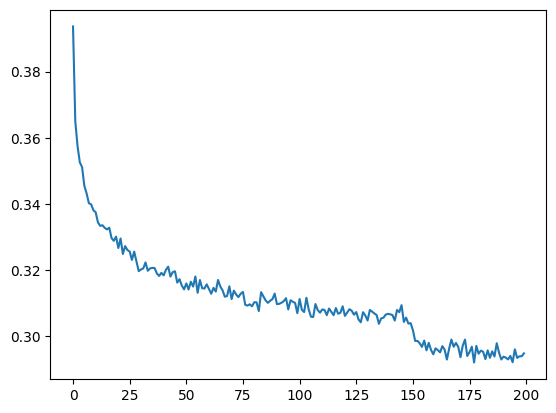

In [82]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
torch.arange(10).view(2,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [53]:
#put layers in eval mode
for layer in model.layers:
    layer.training = False

In [83]:
@torch.no_grad() #disable grad tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 1.940172553062439
val 2.0350000858306885


Performance log

- original ( 3char context, 200 neurons, 12k params): train 2.2592, val 2.3490
- 8 char context: train 2-1270, val 2.2990
- Hierarchical layers: train 1.9401, val 2.0350

In [41]:
#sample from model

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join(itos[i] for i in out))

maddisa.
mika.
katalik.
katif.
farrabella.
kayce.
melizabelland.
thanthon.
natavia.
torianny.
kadrick.
faileighthan.
yulion.
jaxsinorahmanvika.
khalexi.
cord.
jaylahnaylon.
abristianny.
christin.
wilbaarius.
